# Overview

# Camera Setup

- Product
  - https://www.wyze.com/products/wyze-cam
- RTSP
  - https://support.wyze.com/hc/en-us/articles/360026245231-Wyze-Cam-RTSP
- Data collection in opencv

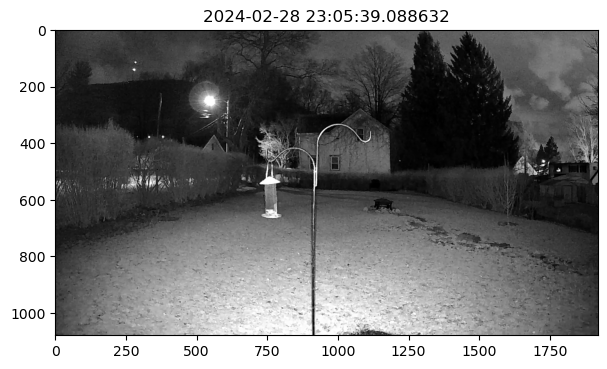

In [2]:
import cv2
import datetime
from IPython.display import clear_output
import matplotlib.pyplot as plt
import os
import time
%matplotlib inline

# rtsp username and password are define within the wyze app
# store password in environment variables
# never hard code passwords and store on a public site such as github!
username = os.environ['RTSP_USERNAME']
password = os.environ['RTSP_PASSWORD']

# url on local network
url = '192.168.1.176'

# rtsp connection string
rtsp = f'rtsp://{username}:{password}@{url}/live'

# video capture
cap = cv2.VideoCapture(rtsp)

# begin endless loop (always a good idea)
while True:
    # set framerate to frames per second
    time.sleep(0.5)

    # get current timestamp
    now = datetime.datetime.now()

    # read frame
    valid, frame = cap.read()

    # check for valid frame
    if valid:
        # write image to file
        cv2.imwrite(f'images/{now.strftime("%Y%m%d_%H%M%S%f")}.jpg', frame)

        # display image
        clear_output(wait=True)
        fig, ax = plt.subplots(figsize=(7, 7))
        ax.imshow(frame[:, :, ::-1])
        ax.set_title(now)
        plt.show()
    else:
        # in case of frame read failure, attempt to reconnect 
        cap.release()
        cap = cv2.VideoCapture(rtsp)

    # break for the sake of this demo
    break

# Bird Detection
- COCO Dataset
  - https://cocodataset.org/
- Facebook DETR
  - https://github.com/facebookresearch/detr

# Bird Classification

### Datasets
- https://www.vision.caltech.edu/datasets/cub_200_2011/
- https://www.kaggle.com/datasets/akash2907/bird-species-classification

### Models
- https://pytorch.org/hub/nicolalandro_ntsnet-cub200_ntsnet/

# Insights
- Types of birds observed to date
  - House sparrow
  - House finch
  - Cardinal
  - Black capped chickadee
  - Dark eyed junco
  - Squirrel
  - Cat
- Time of day variation

# Next Steps
- Incorporate temporal information
- Reporting to Cornell eBird

# Other applications
- Astronomy
- Time lapses